# Segmenting and Clustering Neighborhoods in Vancouver City - Outdoors & Recreation

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from urllib.request import urlopen
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import seaborn as sns
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# website scraping libraries and packages in Python from BeautifulSoup 
from bs4 import BeautifulSoup
from bs4 import BeautifulSoup as bsoup

# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')

Libraries imported.


In [2]:
# Vancouver neighborhoods
van_neighborhoods = ['Arbutus Ridge', 'Cedar Cottage', 'Champlain Heights', 'Chinatown', 'Coal Harbour', 'Collingwood',
                     'Commercial Drive', 'Creekside', 'Downtown', 'Downtown Eastside', 'Dunbar-Southlands', 'Fairview',
                     'False Creek North', 'False Creek South', 'Gastown', 'Grandview-Woodland', 'Granville Island',
                     'Hastings-Sunrise', 'Hastings Crossing', 'Hastings East', 'Kensington-Cedar Cottage', 'Kerrisdale',
                     'Killarney', 'Kitsilano', 'Knight', 'Langara', 'Little Mountain', 'Main', 'Marpole', 'Mole Hill',
                     'Mount Pleasant', 'Musqueam', 'Oakridge', 'Quilchena', 'Renfrew-Collingwood', 'Riley Park',
                     'Shaughnessy', 'South Cambie', 'South Granville', 'South Hill', 'South Vancouver', 'Southlands',
                     'Southwest Marine', 'Sunrise', 'Sunset', 'Victoria-Fraserview', 'West Broadway', 'West End', 'West Point Grey', 'Yaletown']

In [3]:
df_van = pd.DataFrame(van_neighborhoods)
df_van.columns = ['Neighborhood']
df_van.head()

,Neighborhood
0,Arbutus Ridge
1,Cedar Cottage
2,Champlain Heights
3,Chinatown
4,Coal Harbour


In [4]:
#create a function to handle TimeOuts from Geocoder
from geopy.exc import GeocoderTimedOut
locator = Nominatim(user_agent = "bostonagent")

def do_geocode(address):
    try:
        return locator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [5]:
neighborhoods = df_van.values.tolist()

latitude = []
longitude = []
for neighborhood in neighborhoods:
    coord = do_geocode('{}, Vancouver'.format(neighborhood))
    
    #check to make sure all latitude and longitude values are present in the Nominatim API
    #handles the case where Nominatim returns a 'None' object because the neighborhood does not exist in their API
    
    if (coord == None):
        latitude.append('0')
        longitude.append('0')
    else:
        latitude.append(coord.latitude)
        longitude.append(coord.longitude)

#add coordinates columns to dataframe
df_van['Latitude'] = latitude
df_van['Longitude'] = longitude

df_van.head()

,Neighborhood,Latitude,Longitude
0,Arbutus Ridge,49.240968,-123.167001
1,Cedar Cottage,49.251622,-123.064548
2,Champlain Heights,49.215266,-123.030915
3,Chinatown,49.279981,-123.104089
4,Coal Harbour,49.290375,-123.129281


In [6]:
address = 'Vancouver City'

#Get lat/long values for Vancouver and print them
location = do_geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinates of Vancouver are {latitude:.4f}, {longitude:.4f}.')

The geograpical coordinates of Vancouver are 49.2609, -123.1140.


In [7]:
CLIENT_ID = 'xxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [8]:
# Explore Neighborhoods in Vancouver

LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('.', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06377d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Create a new dataframe called Vancouver_venues
van_venues = getNearbyVenues(names=df_van['Neighborhood'],
                                   latitudes=df_van['Latitude'],
                                   longitudes=df_van['Longitude'])
print('\nDone!')

..................................................
Done!


In [9]:
#DataFrame of the most frequent venues in Vancouver

#group by category
mostpop= van_venues.groupby('Venue Category').count()

#sort values in descending order
mostpop = mostpop.sort_values(by = 'Neighborhood', ascending = False)

#select only the top 10 venues
mostpop= mostpop[0:10]

#reset index for visualization
mostpop.reset_index(inplace=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


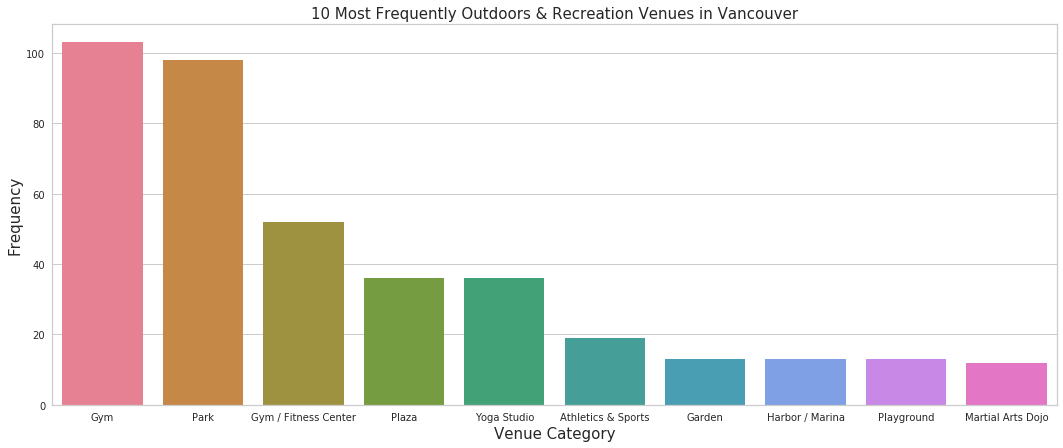

In [10]:
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Neighborhood",  palette="husl",saturation = 0.75, data=mostpop)
sns.set_context("paper")
s.set_xticklabels(s.get_xticklabels())
plt.title('10 Most Frequently Outdoors & Recreation Venues in Vancouver', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()
fig.savefig('10most-common-O&R-ven-Vancouver.png', dpi=300)

In [11]:
# Checking the size of the resulting dataframe
print(van_venues.shape)
van_venues.head()

(504, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,49.240968,-123.167001,Spire Wellness,49.242474,-123.169867,Yoga Studio
1,Arbutus Ridge,49.240968,-123.167001,Van Exer-tech Services Inc,49.240596,-123.163342,Gym / Fitness Center
2,Arbutus Ridge,49.240968,-123.167001,Triangle Park,49.245061,-123.167914,Park
3,Cedar Cottage,49.251622,-123.064548,Trout Lake Community Centre,49.255403,-123.065048,Gym
4,Cedar Cottage,49.251622,-123.064548,Trout Lake Fitness Centre,49.255601,-123.065317,Gym / Fitness Center


In [12]:
# Checking how many veneus were returned for each neighborhood
van_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arbutus Ridge,3,3,3,3,3,3
Cedar Cottage,5,5,5,5,5,5
Champlain Heights,4,4,4,4,4,4
Chinatown,40,40,40,40,40,40
Coal Harbour,20,20,20,20,20,20


In [13]:
# Analyze Each Neighborhood

# one hot encoding
van_onehot = pd.get_dummies(van_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
van_onehot['Neighborhood'] = van_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [van_onehot.columns[-1]] + list(van_onehot.columns[:-1])
van_onehot = van_onehot[fixed_columns]

print(van_onehot.shape)
van_onehot.head()

(504, 41)


,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Beach,Botanical Garden,Boxing Gym,Cycle Studio,Dog Run,Fountain,Garden,Golf Course,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hockey Rink,Lake,Lighthouse,Martial Arts Dojo,Nature Preserve,Park,Pedestrian Plaza,Playground,Plaza,Pool,Recreation Center,Roof Deck,Scenic Lookout,Sculpture Garden,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Surf Spot,Tennis Court,Track,Trail,Vineyard,Yoga Studio
0,Arbutus Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Arbutus Ridge,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arbutus Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cedar Cottage,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Cedar Cottage,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
van_grouped = van_onehot.groupby('Neighborhood').mean().reset_index()
print(van_grouped.shape)
van_grouped.head()

(50, 41)


,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Beach,Botanical Garden,Boxing Gym,Cycle Studio,Dog Run,Fountain,Garden,Golf Course,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hockey Rink,Lake,Lighthouse,Martial Arts Dojo,Nature Preserve,Park,Pedestrian Plaza,Playground,Plaza,Pool,Recreation Center,Roof Deck,Scenic Lookout,Sculpture Garden,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Surf Spot,Tennis Court,Track,Trail,Vineyard,Yoga Studio
0,Arbutus Ridge,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.00,0.333333,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.333333,0.0,0.000,0.000,0.000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
1,Cedar Cottage,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.20,0.200000,0.0,0.0,0.000,0.2,0.0,0.000,0.0,0.200000,0.0,0.000,0.000,0.000,0.00,0.0,0.00,0.00,0.00,0.20,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,Champlain Heights,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.25,0.000000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.250000,0.0,0.250,0.000,0.000,0.25,0.0,0.00,0.00,0.00,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,Chinatown,0.075,0.0,0.025,0.0,0.0,0.025,0.025,0.0,0.0,0.025,0.0,0.25,0.050000,0.0,0.0,0.025,0.0,0.0,0.025,0.0,0.050000,0.0,0.025,0.175,0.025,0.00,0.0,0.00,0.05,0.05,0.00,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.075000
4,Coal Harbour,0.050,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.30,0.050000,0.0,0.1,0.000,0.0,0.0,0.000,0.0,0.250000,0.0,0.000,0.000,0.000,0.05,0.0,0.05,0.00,0.00,0.05,0.0,0.000,0.0,0.0,0.0,0.0,0.1,0.0,0.000000


In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = van_grouped['Neighborhood']

for ind in np.arange(van_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Yoga Studio,Gym / Fitness Center,Park,Basketball Court,Gym,Lighthouse,Lake,Hockey Rink,Harbor / Marina,Gym Pool
1,Cedar Cottage,Park,Lake,Gym / Fitness Center,Gym,Skating Rink,Yoga Studio,Garden,Hockey Rink,Harbor / Marina,Gym Pool
2,Champlain Heights,Park,Playground,Recreation Center,Gym,Yoga Studio,Golf Course,Hockey Rink,Harbor / Marina,Gym Pool,Gym / Fitness Center
3,Chinatown,Gym,Plaza,Yoga Studio,Athletics & Sports,Gym / Fitness Center,Park,Skate Park,Sculpture Garden,Cycle Studio,Hockey Rink
4,Coal Harbour,Gym,Park,Trail,Harbor / Marina,Athletics & Sports,Scenic Lookout,Gym / Fitness Center,Skating Rink,Recreation Center,Gym Pool


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


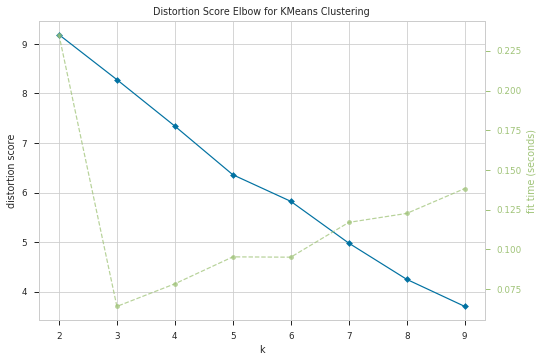

In [17]:
#elbow method to determine best cluster numbers
model = KMeans()
van_grouped_clustering = van_grouped.drop('Neighborhood', 1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(van_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()

In [18]:
# The visualization generated by Yellowbrick indicated that a k value of 5 would produce the most effective clusters for our data
# We will be running our K-means clustering algorithm on our weighted van_grouped DataFrame with this k value after removing the Neighborhood name from the DataFrame
# After we generate our cluster labels, we will add them to our Top 10 Venues DataFrame. Again, this will make it easier for us to understand how k-means clustered our neighborhoods in the future

kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(van_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 3, 3, 3, 1, 1, 3, 3, 3], dtype=int32)

In [19]:
# add clustering labels

#uncomment this line if running block again
#neighborhoods_venues_sorted.drop(columns =['Cluster Labels'], axis = 1, inplace=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

van_merged = df_van

# merge van_grouped with df to add latitude/longitude for each neighborhood
van_merged = van_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

van_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,49.240968,-123.167001,1,Yoga Studio,Gym / Fitness Center,Park,Basketball Court,Gym,Lighthouse,Lake,Hockey Rink,Harbor / Marina,Gym Pool
1,Cedar Cottage,49.251622,-123.064548,3,Park,Lake,Gym / Fitness Center,Gym,Skating Rink,Yoga Studio,Garden,Hockey Rink,Harbor / Marina,Gym Pool
2,Champlain Heights,49.215266,-123.030915,3,Park,Playground,Recreation Center,Gym,Yoga Studio,Golf Course,Hockey Rink,Harbor / Marina,Gym Pool,Gym / Fitness Center
3,Chinatown,49.279981,-123.104089,3,Gym,Plaza,Yoga Studio,Athletics & Sports,Gym / Fitness Center,Park,Skate Park,Sculpture Garden,Cycle Studio,Hockey Rink
4,Coal Harbour,49.290375,-123.129281,3,Gym,Park,Trail,Harbor / Marina,Athletics & Sports,Scenic Lookout,Gym / Fitness Center,Skating Rink,Recreation Center,Gym Pool


In [20]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(van_merged['Latitude'], 
                                  van_merged['Longitude'], 
                                  van_merged['Neighborhood'], 
                                  van_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [21]:
# Cluster 1
van_c1 = van_merged.loc[van_merged['Cluster Labels'] == 0,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c1.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Sunset,Yoga Studio,Garden,Lake,Hockey Rink,Harbor / Marina,Gym Pool,Gym / Fitness Center,Gym,Golf Course


In [22]:
# Cluster 2
van_c2 = van_merged.loc[van_merged['Cluster Labels'] == 1,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c2.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Gym / Fitness Center,Park,Basketball Court,Gym,Lighthouse,Lake,Hockey Rink,Harbor / Marina,Gym Pool
5,Collingwood,Baseball Field,Basketball Court,Golf Course,Lighthouse,Lake,Hockey Rink,Harbor / Marina,Gym Pool,Gym / Fitness Center
6,Commercial Drive,Gym,Gym / Fitness Center,Yoga Studio,Beach,Botanical Garden,Boxing Gym,Cycle Studio,Dog Run,Fountain
11,Fairview,Plaza,Gym / Fitness Center,Yoga Studio,Golf Course,Lake,Hockey Rink,Harbor / Marina,Gym Pool,Gym
15,Grandview-Woodland,Yoga Studio,Gym,Gym / Fitness Center,Baseball Field,Basketball Court,Lighthouse,Lake,Hockey Rink,Harbor / Marina


In [23]:
# Cluster 3
van_c3 = van_merged.loc[van_merged['Cluster Labels'] == 2,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c3.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Southlands,Yoga Studio,Vineyard,Lighthouse,Lake,Hockey Rink,Harbor / Marina,Gym Pool,Gym / Fitness Center,Gym


In [24]:
# Cluster 4
van_c4 = van_merged.loc[van_merged['Cluster Labels'] == 3,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c4.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Cedar Cottage,Lake,Gym / Fitness Center,Gym,Skating Rink,Yoga Studio,Garden,Hockey Rink,Harbor / Marina,Gym Pool
2,Champlain Heights,Playground,Recreation Center,Gym,Yoga Studio,Golf Course,Hockey Rink,Harbor / Marina,Gym Pool,Gym / Fitness Center
3,Chinatown,Plaza,Yoga Studio,Athletics & Sports,Gym / Fitness Center,Park,Skate Park,Sculpture Garden,Cycle Studio,Hockey Rink
4,Coal Harbour,Park,Trail,Harbor / Marina,Athletics & Sports,Scenic Lookout,Gym / Fitness Center,Skating Rink,Recreation Center,Gym Pool
7,Creekside,Playground,Recreation Center,Gym,Yoga Studio,Golf Course,Hockey Rink,Harbor / Marina,Gym Pool,Gym / Fitness Center


In [25]:
# Cluster 5
van_c5 = van_merged.loc[van_merged['Cluster Labels'] == 4,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c5.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Knight,Yoga Studio,Vineyard,Lighthouse,Lake,Hockey Rink,Harbor / Marina,Gym Pool,Gym,Golf Course


In [26]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


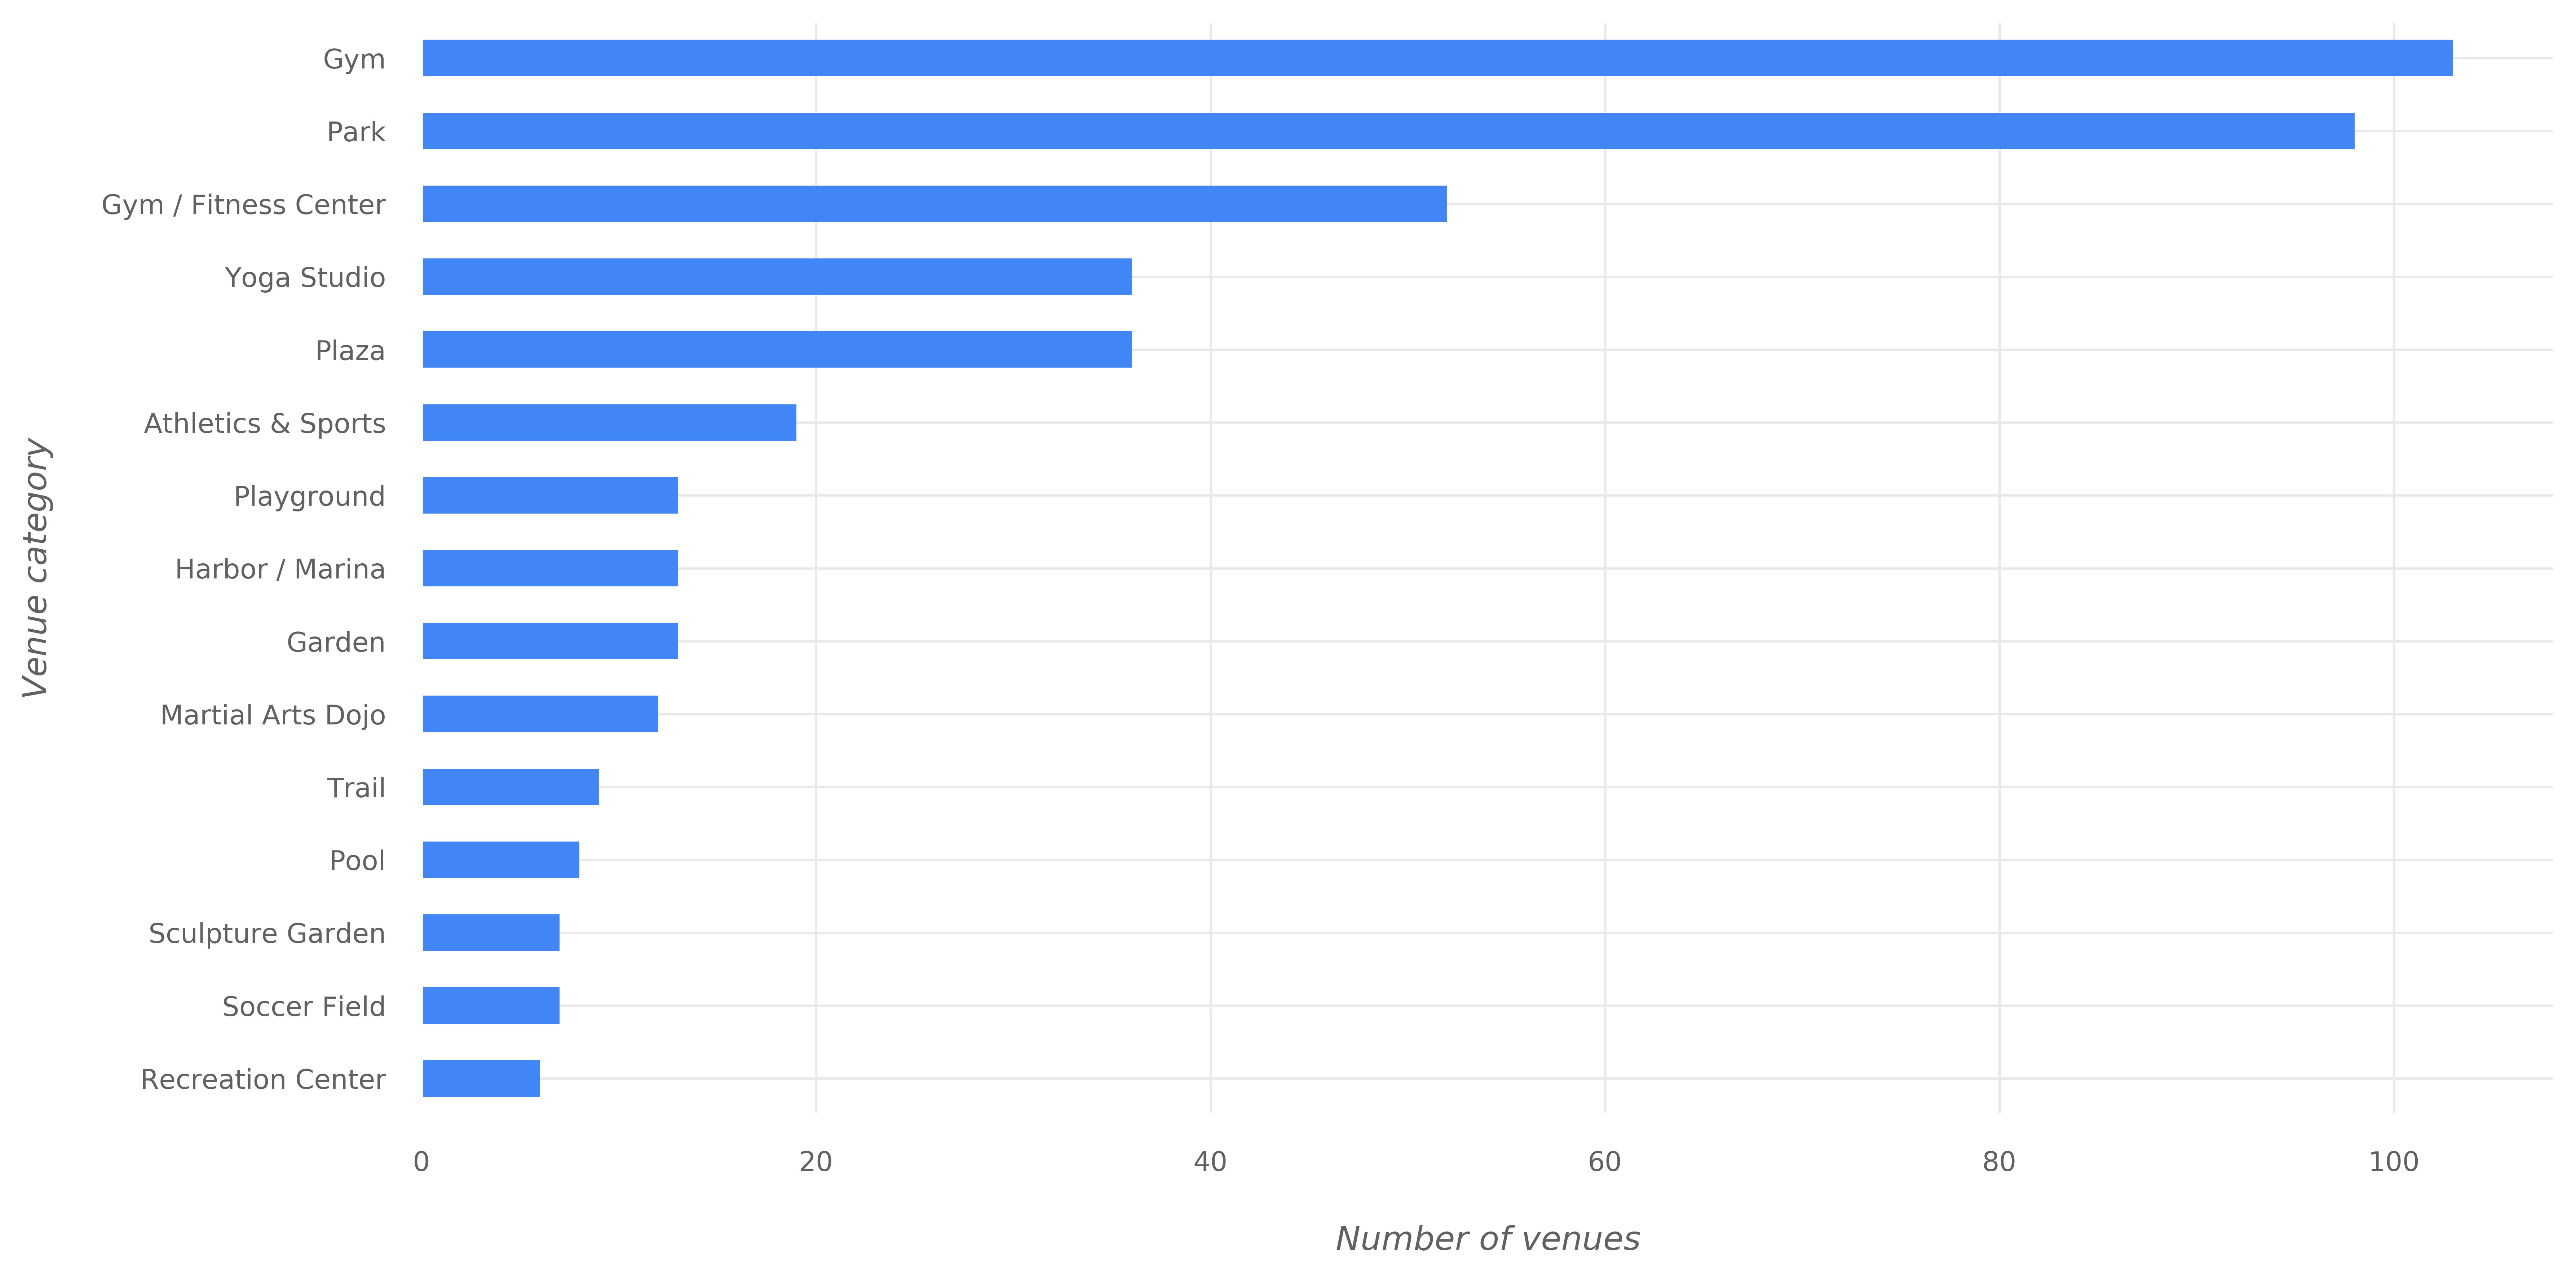

In [27]:
# Most Common Outdoors & Recreation Venue Categories in Vancouver

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
van_top_vc = van_venues['Venue Category'].value_counts(normalize=False)
ax = van_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-O&R-Vancouver.png', dpi=300)

50 neighborhoods in Vancouver


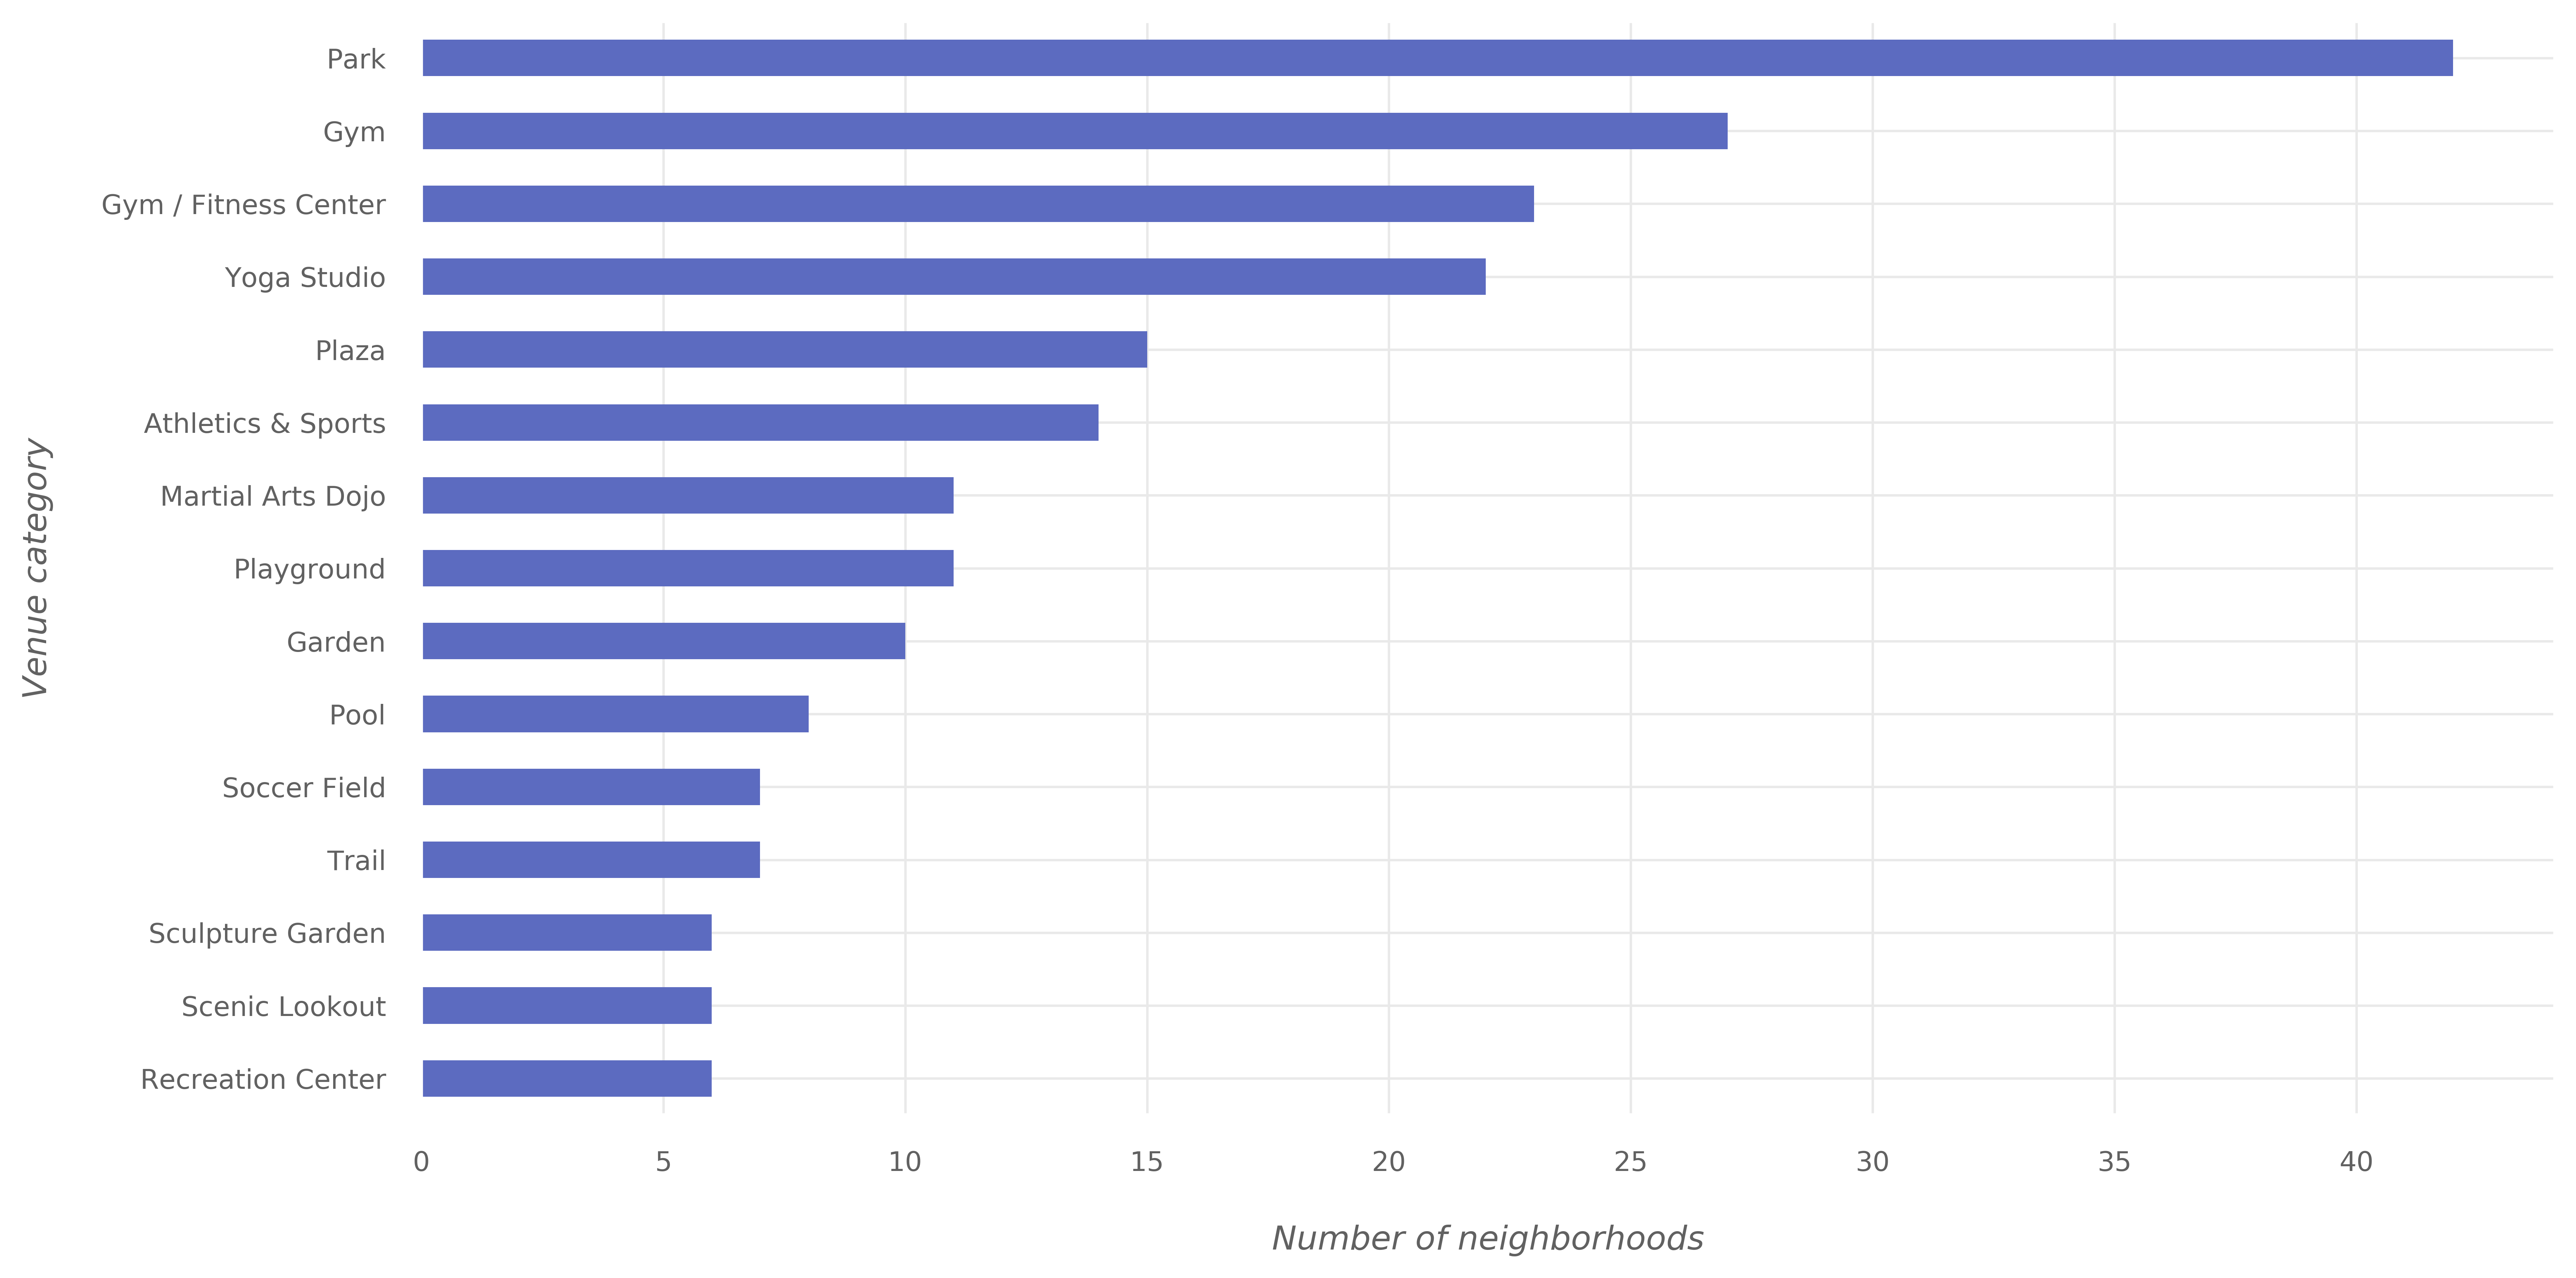

In [28]:
# Which Outdoors & Recreation Venue Exist in More Vancouver Neighborhoods?

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
van_g = van_onehot.groupby('Neighborhood').max().reset_index()
van_p = van_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print(f"{van_g.shape[0]} neighborhoods in Vancouver")
ax = van_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-O&R-Vancouver.png', dpi=300)

In [29]:
# Rare Outdoors & Recreation Categories in Vancouver

van_bot_vc = van_venues['Venue Category'].value_counts(normalize=False)
van_bot_vc = van_bot_vc.tail(15).to_frame('Count')
van_bot_vc.index.names = ['Venue Category']
van_bot_vc

,Count
Venue Category,
Tennis Court,3
Dog Run,3
Lighthouse,2
Ski Area,2
Beach,2
Lake,2
Baseball Field,2
Track,2
Fountain,1
